In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import shap
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import numpy as np
import seaborn as sns

In [2]:
# Load dataset
data = pd.read_csv("D:/ckd project/kidney_disease.csv")  



In [3]:
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [5]:
# Replace problematic characters (like '\t' and '?') with NaN
data.replace(r'[\t?]', np.nan, regex=True, inplace=True)
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [6]:
# Drop unnecessary columns and set target variable
X = data.drop(columns=['classification', 'id'])
X
y = data['classification'].apply(lambda x: 1 if x == 'ckd' else 0)
y

0      1
1      1
2      1
3      1
4      1
      ..
395    0
396    0
397    0
398    0
399    0
Name: classification, Length: 400, dtype: int64

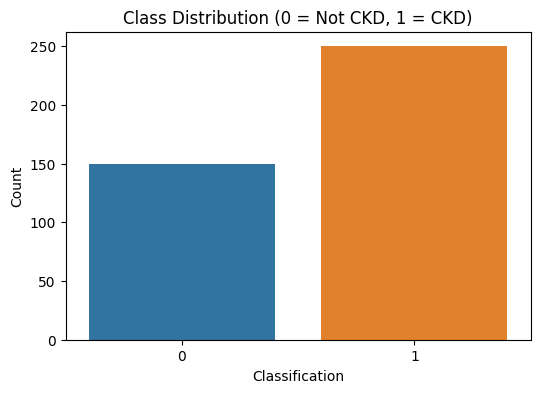

In [24]:
#Target Variable Analysis
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Class Distribution (0 = Not CKD, 1 = CKD)")
plt.xlabel("Classification")
plt.ylabel("Count")
plt.show()


In [25]:
# Print target balance information
print("Target Variable Distribution:")
print(y.value_counts(normalize=True))

Target Variable Distribution:
classification
1    0.625
0    0.375
Name: proportion, dtype: float64


In [8]:
# Step 1: Handle Missing Values Separately for Numeric and Categorical Features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Impute numeric and categorical features
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')
X[numeric_features] = num_imputer.fit_transform(X[numeric_features])
X[categorical_features] = cat_imputer.fit_transform(X[categorical_features])
#step 2:
X = pd.get_dummies(X, columns=categorical_features, drop_first=False)  

# Step 3: Scaling Numeric Features
scaler = MinMaxScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Step 5: Convert to float for compatibility with XGBoost
X_train = X_train.astype(float)
X_test = X_test.astype(float)


In [9]:
X_train

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,dm_no,dm_yes,cad_no,cad_yes,appet_good,appet_poor,pe_no,pe_yes,ane_no,ane_yes
364,0.806818,0.230769,1.000000,0.00000,0.000000,0.205128,0.109114,0.003968,0.835962,0.022472,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
135,0.522727,0.230769,0.500000,0.00000,0.400000,0.410256,0.057766,0.011905,0.854890,0.033708,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
322,0.772727,0.076923,0.620397,0.20339,0.090028,0.209402,0.098845,0.001323,0.854890,0.047191,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
234,0.397727,0.384615,0.250000,0.00000,0.000000,0.269309,0.044929,0.011905,0.839298,0.047803,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
388,0.556818,0.230769,0.750000,0.00000,0.000000,0.153846,0.034660,0.010582,0.880126,0.026966,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.562311,0.307692,0.620397,0.20339,0.090028,0.395299,0.201540,0.084656,0.867508,0.067416,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
30,0.562311,0.153846,0.620397,0.20339,0.090028,0.151709,0.394095,0.091270,0.804416,0.053933,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
346,0.352273,0.076923,0.620397,0.20339,0.090028,0.230769,0.101412,0.006614,0.861199,0.042697,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
137,0.488636,0.076923,0.250000,0.40000,0.000000,0.525641,0.216945,0.047619,0.817035,0.058427,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [10]:
X_test


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,dm_no,dm_yes,cad_no,cad_yes,appet_good,appet_poor,pe_no,pe_yes,ane_no,ane_yes
127,0.784091,0.076923,0.500000,0.80000,0.000000,0.205128,0.317073,0.064815,0.829653,0.053933,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
356,0.363636,0.153846,1.000000,0.00000,0.000000,0.138889,0.093710,0.001323,0.880126,0.051685,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
128,0.568182,0.307692,0.500000,0.80000,0.600000,0.431624,0.422336,0.068783,0.810726,1.000000,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
298,0.363636,0.076923,0.750000,0.00000,0.000000,0.147436,0.121951,0.010582,0.823344,0.044944,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
217,0.693182,0.384615,0.250000,0.20000,0.000000,0.119658,0.152760,0.018519,0.861199,0.042697,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0.318182,0.230769,1.000000,0.00000,0.000000,0.158120,0.060334,0.001323,0.880126,0.051685,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
233,0.556818,0.384615,0.500000,0.40000,0.000000,0.151709,0.047497,0.015873,0.892744,0.044944,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
133,0.772727,0.384615,0.500000,0.80000,0.000000,0.205128,0.317073,0.064815,0.829653,0.053933,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
151,0.840909,0.307692,0.620397,0.20339,0.090028,0.320513,0.114249,0.017196,0.861199,0.067416,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [11]:
def select_features_for_model(model_name, X_train, y_train):
    X_train_selected = None

    if model_name == 'Random Forest':
        # ANOVA for numerical feature
        numerical_features_to_select = ['hemo']
        available_numerical_features = [f for f in numerical_features_to_select if f in X_train.columns]
        if available_numerical_features:
            anova_selector = SelectKBest(k=len(available_numerical_features))
            X_train_selected = anova_selector.fit_transform(X_train[available_numerical_features], y_train)
        
        # RFE for nominal features
        nominal_features_to_select = ['htn_yes', 'dm_yes', 'appet_good', 'rbc_normal']
        available_nominal_features = [f for f in nominal_features_to_select if f in X_train.columns]
        if available_nominal_features:
            rfe_selector = RFE(estimator=LogisticRegression(max_iter=500), n_features_to_select=len(available_nominal_features))
            X_train_rfe = rfe_selector.fit_transform(X_train[available_nominal_features], y_train)
            if X_train_selected is not None:
                X_train_selected = np.concatenate((X_train_selected, X_train_rfe), axis=1)
            else:
                X_train_selected = X_train_rfe

    elif model_name == 'Extra Trees':
        # Mutual Information for numeric features
        numerical_features_to_select = ['hemo', 'pcv', 'rc', 'sc']
        available_numerical_features = [f for f in numerical_features_to_select if f in X_train.columns]
        if available_numerical_features:
            mutual_info_selector = SelectKBest(mutual_info_classif, k=len(available_numerical_features))
            X_train_selected = mutual_info_selector.fit_transform(X_train[available_numerical_features], y_train)

        # Chi-squared for nominal features
        nominal_features_to_select = ['htn_yes', 'dm_yes', 'appet_good', 'pe_yes']
        available_nominal_features = [f for f in nominal_features_to_select if f in X_train.columns]
        if available_nominal_features:
            chi2_selector = SelectKBest(chi2, k=len(available_nominal_features))
            chi2_selected = chi2_selector.fit_transform(X_train[available_nominal_features], y_train)
            if X_train_selected is not None:
                X_train_selected = np.concatenate((X_train_selected, chi2_selected), axis=1)
            else:
                X_train_selected = chi2_selected

    elif model_name == 'AdaBoost':
        # Mutual Information is applied to both numeric and nominal features to select the most relevant ones.
        numerical_features_to_select = ['hemo', 'pcv', 'rc', 'sc', 'sod', 'pot', 'wc']
        available_numerical_features = [f for f in numerical_features_to_select if f in X_train.columns]
        if available_numerical_features:
            mutual_info_selector = SelectKBest(mutual_info_classif, k=len(available_numerical_features))
            X_train_selected = mutual_info_selector.fit_transform(X_train[available_numerical_features], y_train)

        # Mutual Information for nominal features
        nominal_features_to_select = ['htn_yes', 'dm_yes', 'appet_good', 'pe_yes']
        available_nominal_features = [f for f in nominal_features_to_select if f in X_train.columns]
        if available_nominal_features:
            mutual_info_selector_nominal = SelectKBest(mutual_info_classif, k=len(available_nominal_features))
            mutual_info_selected = mutual_info_selector_nominal.fit_transform(X_train[available_nominal_features], y_train)
            if X_train_selected is not None:
                X_train_selected = np.concatenate((X_train_selected, mutual_info_selected), axis=1)
            else:
                X_train_selected = mutual_info_selected

    elif model_name == 'XGBoost':
        # XGBoost uses only three features: hemo, htn, sg
        selected_features = ['hemo', 'htn_yes', 'sg']
        available_selected_features = [f for f in selected_features if f in X_train.columns]
        if available_selected_features:
            X_train_selected = X_train[available_selected_features]

    return X_train_selected


In [12]:
print("Available columns in X_train:", X_train.columns)


Available columns in X_train: Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot',
       ...
       'dm_no', 'dm_yes', 'cad_no', 'cad_yes', 'appet_good', 'appet_poor',
       'pe_no', 'pe_yes', 'ane_no', 'ane_yes'],
      dtype='object', length=208)


In [13]:
# Step 6: Model Training and Evaluation with Cross-Validation and Grid Search
models = {
    'Random Forest': RandomForestClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

param_grids = {
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [3, 5, 7]},
    'Extra Trees': {'n_estimators': [50, 100], 'max_features': ['sqrt', 'log2']},
    'AdaBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'XGBoost': {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.3]}
}


In [14]:
for name, model in models.items():
    X_train_selected = select_features_for_model(name, X_train, y_train)
    X_test_selected = select_features_for_model(name, X_test, y_test)
    
    # Grid Search for Hyperparameter Tuning
    grid_search = GridSearchCV(model, param_grids[name], cv=5)
    grid_search.fit(X_train_selected, y_train)

    # Evaluate the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_selected)
    print(f"=== {name} ===")
    print("Best Parameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.score(X_test_selected, y_test) * 100)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

=== Random Forest ===
Best Parameters: {'max_depth': 3, 'n_estimators': 50}
Accuracy: 95.83333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95        45
           1       0.97      0.96      0.97        75

    accuracy                           0.96       120
   macro avg       0.95      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120

Confusion Matrix:
 [[43  2]
 [ 3 72]]
=== Extra Trees ===
Best Parameters: {'max_features': 'sqrt', 'n_estimators': 50}
Accuracy: 96.66666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        45
           1       1.00      0.95      0.97        75

    accuracy                           0.97       120
   macro avg       0.96      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120

Confusion Matrix:
 [[45  0]
 [ 4 71]]
=== AdaB

C:\Users\ABISHEK\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:32:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\ABISHEK\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:32:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\ABISHEK\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:32:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\ABISHEK\anaconda3\Lib\site-p

=== XGBoost ===
Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50}
Accuracy: 98.33333333333333
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        45
           1       0.97      1.00      0.99        75

    accuracy                           0.98       120
   macro avg       0.99      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120

Confusion Matrix:
 [[43  2]
 [ 0 75]]


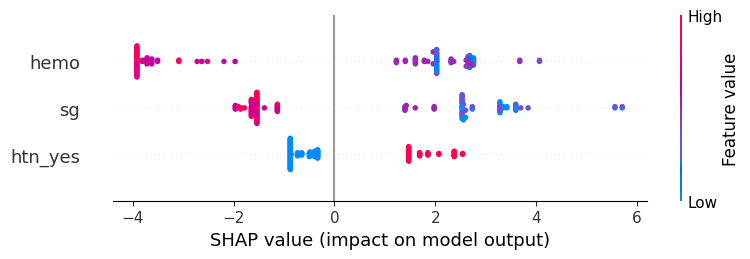


SHAP Explanation for Positive Case (CKD):


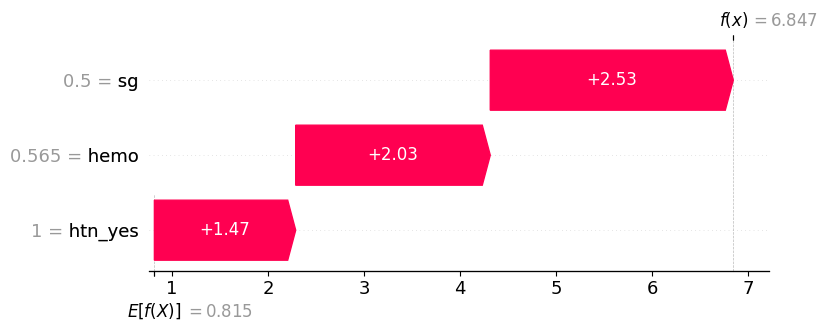


SHAP Explanation for Negative Case (non-CKD):


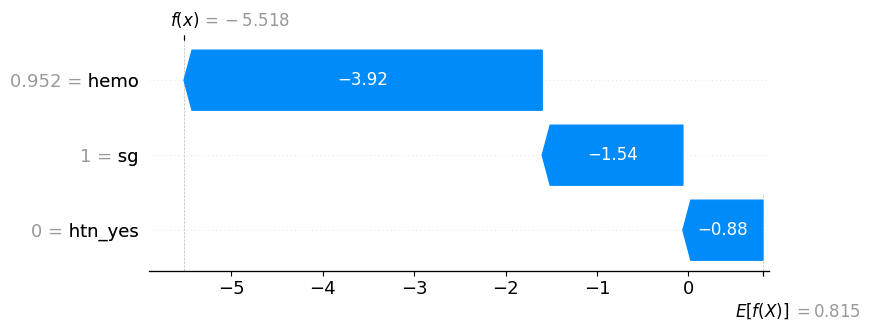

In [16]:
 # SHAP Analysis for XGBoost if the model is XGBoost
if name == 'XGBoost':
        # Ensure data is compatible for SHAP by using float type
        X_test_selected = X_test_selected.astype(float)
        
        # Initialize SHAP TreeExplainer for the XGBoost model
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_selected)
    
        # Plot SHAP summary for global feature importance
        shap.summary_plot(shap_values, X_test_selected, feature_names=['hemo', 'htn_yes', 'sg'])
        
        # Select one sample each from positive and negative cases
        positive_case = X_test_selected[y_test.values == 1].iloc[0:1]  # First instance of class 1 (CKD)
        negative_case = X_test_selected[y_test.values == 0].iloc[0:1]  # First instance of class 0 (non-CKD)
        
        # Compute SHAP values for the selected samples
        positive_shap_values = explainer(positive_case)
        negative_shap_values = explainer(negative_case)
        
        # Display the waterfall plot for the positive case
        print("\nSHAP Explanation for Positive Case (CKD):")
        shap.waterfall_plot(positive_shap_values[0], max_display=5)
    
        # Display the waterfall plot for the negative case
        print("\nSHAP Explanation for Negative Case (non-CKD):")
        shap.waterfall_plot(negative_shap_values[0], max_display=5)
